In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from floquet_simulations.hamiltonians import GetEvalsAndEvecsGen, RoundComplex
from floquet_simulations.plot_functions import PlotAbsRealImagHamiltonian, PlotParams
from scipy.special import jv


In [33]:
def H0(N):
    return np.diag(-np.ones(N-1),-1)+np.diag(-np.ones(N-1),1)       

def HT(H0, funcs, sites, t):

    for func, site in zip(funcs, sites):
        H0[site-1,site-1] = func(t)
    return H0

def FT(t, psi, H0, funcs, sites):
    H = HT(H0, funcs, sites, t)
    return -1j*np.dot(H, psi)

def SolveSchrodinger(H0, funcs, sites, tspan, n_timesteps, psi0):
    
    rtol=1e-11
    # points to calculate the matter wave at
    t_eval = np.linspace(tspan[0], tspan[1], n_timesteps+1, endpoint=True)
    sol = solve_ivp(lambda t,psi: FT(t, psi, H0, funcs, sites), 
            t_span=tspan, y0=psi0, rtol=rtol, 
            atol=rtol, t_eval=t_eval,
            method='RK45')
    sol=sol.y
    return sol


def CreateHF(H0, funcs, sites, T, num_sites, t0=0, hermitian_accuracy_dp=7): 
    """
    t0 is fraction of T
    """

    #sanity check
    assert(len(H0) == num_sites)
    
    tspan = (t0*T,T+t0*T)
    UT = np.zeros([num_sites, num_sites], dtype=np.complex_)
    n_timesteps = 100
    
    for A_site_start in range(num_sites):
        psi0 = np.zeros(num_sites, dtype=np.complex_); psi0[A_site_start] = 1
        sol = SolveSchrodinger(H0, funcs, sites, tspan, n_timesteps, psi0)
        UT[:,A_site_start]=sol[:,-1] 
    
    # evals_U, evecs = eig(UT)
    evals_U, evecs = GetEvalsAndEvecsGen(UT) #evals can be imaginary
    evals_H = 1j / T *np.log(evals_U)
    
    HF = np.zeros([num_sites,num_sites], dtype=np.complex_)
    for i in range(num_sites):
        term = evals_H[i]*np.outer(evecs[:,i], np.conj(evecs[:,i]))
        HF = HF+term

    HF = RoundComplex(HF, hermitian_accuracy_dp)
    return UT, HF

def step_function(x, T1, T):
    xp = x%T
    if (np.floor(xp/T1) == 0):
        return 1
    else:
        return 0

In [121]:
omega = 20

A = 50
T1 = 2*np.pi/omega
phi = np.pi*0.2
print(jv(0,A/omega))
sites = [5]
tunnelling_elements = []
num_checks = 40
T_checks = np.linspace(1,20,num_checks)
A_vals = np.linspace(0,10,40)
for A_val in A_vals:
    T = T1*2.1
    funcs = [lambda x: A_val*np.cos(omega*x + phi)*step_function(x, T1, T)]


    _, HF = CreateHF(H0(10), funcs, sites, T, num_sites=10, t0=0, hermitian_accuracy_dp=7)
    tunnelling_elements.append(HF[5,6])

-0.04838377646819789


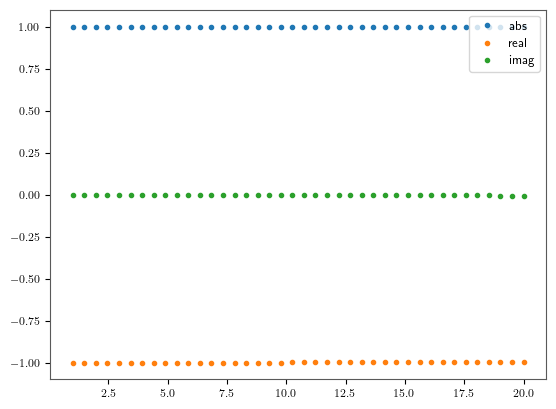

In [122]:
fig, ax = plt.subplots()
ax.plot(T_checks, np.abs(tunnelling_elements), '.', label="abs")
ax.plot(T_checks, np.real(tunnelling_elements), '.', label="real")
ax.plot(T_checks, np.imag(tunnelling_elements), '.', label="imag")
# ax.plot(T_checks, np.angle(tunnelling_elements) %(2*np.pi)  -np.pi, '.', label="angle")
ax.legend()
plt.show()

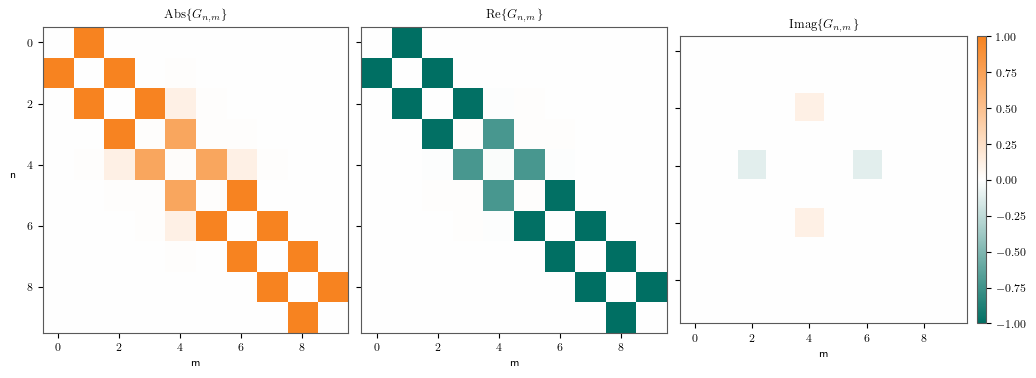

In [104]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
figsize = (25,25)
colourbar_pad=0.1; colourbar_size_percentage=3
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

'''abs real imag'''

apply = [
            np.abs, 
            np.real, np.imag]
labels = [
            r'$\mathrm{Abs}\{G_{n,m}\}$', 
            r'$\mathrm{Re}\{G_{n,m}\}$',
            r'$\mathrm{Imag}\{G_{n,m}\}$'
            ]

cmap = mpl.colors.LinearSegmentedColormap.from_list('custom hamiltonians', ['#006F63', "#FFFFFF", '#F78320'], N=256)
cm_unit = 1/2.54
fig, ax = plt.subplots(nrows=1, ncols=len(apply), sharey=True, constrained_layout=True, 
                        figsize=(figsize[0]*cm_unit, figsize[1]*cm_unit))

for n1, f in enumerate(apply):
    pcm = ax[n1].matshow(f(HF), interpolation='none', cmap=cmap,  norm=norm)
    ax[n1].set_title(labels[n1])
    ax[n1].tick_params(axis="x", bottom=True, top=False, labelbottom=True, 
        labeltop=False)  
    ax[n1].set_xlabel('m')

ax[0].set_ylabel('n', rotation=0, labelpad=10)

divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size=f"{colourbar_size_percentage}%", pad=colourbar_pad)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)# label="unweighted graph distance")

plt.show()
